## Data Processing and Modeling

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

### Section 1: Data Processing

#### 0. Read and overview dataset

In [74]:
df = pd.read_csv("../Data/earthquake_tsunami_raw_data.csv")
# check base info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758 entries, 0 to 1757
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1758 non-null   object 
 1   magnitude  1758 non-null   float64
 2   cdi        1336 non-null   float64
 3   mmi        1756 non-null   float64
 4   sig        1758 non-null   int64  
 5   nst        543 non-null    float64
 6   dmin       1654 non-null   float64
 7   gap        1737 non-null   float64
 8   depth      1758 non-null   float64
 9   latitude   1758 non-null   float64
 10  longitude  1758 non-null   float64
 11  year       1758 non-null   int64  
 12  month      1758 non-null   int64  
 13  tsunami    1758 non-null   int64  
 14  place      1756 non-null   object 
 15  alert      1751 non-null   object 
 16  magType    1758 non-null   object 
 17  rms        1756 non-null   float64
 18  code       1758 non-null   object 
 19  net        1758 non-null   object 
 20  type    

In [75]:
# check unique values
for col in df.columns:
    n_unique = df[col].nunique()
    print(f"{col:20s}: {n_unique:6d} unique values")

title               :   1584 unique values
magnitude           :     27 unique values
cdi                 :     71 unique values
mmi                 :   1263 unique values
sig                 :    443 unique values
nst                 :    286 unique values
dmin                :   1455 unique values
gap                 :    158 unique values
depth               :    590 unique values
latitude            :   1758 unique values
longitude           :   1754 unique values
year                :     13 unique values
month               :     12 unique values
tsunami             :      2 unique values
place               :   1366 unique values
alert               :      4 unique values
magType             :      7 unique values
rms                 :    130 unique values
code                :   1758 unique values
net                 :      7 unique values
type                :      2 unique values
status              :      1 unique values
datetime            :   1758 unique values


In [76]:
# check target value distribution
year_stats = df.groupby('year').agg({
    'tsunami': ['count', 'sum', 'mean']
}).round(3)

year_stats.columns = ['total_earthquakes', 'tsunami_count', 'tsunami_rate']
year_stats = year_stats.reset_index()

print("\nYear-wise Statistics:")
print(year_stats)


Year-wise Statistics:
    year  total_earthquakes  tsunami_count  tsunami_rate
0   2013                142             48         0.338
1   2014                155             59         0.381
2   2015                146             46         0.315
3   2016                147             46         0.313
4   2017                111             45         0.405
5   2018                134             50         0.373
6   2019                145             46         0.317
7   2020                121             33         0.273
8   2021                157             45         0.287
9   2022                127             45         0.354
10  2023                147             42         0.286
11  2024                 99             36         0.364
12  2025                127             43         0.339


#### 1. Drop unnecessary columns <br>
Drop columns that are not needed for the analysis. The columns are:
- `title`: Combination of 'magnitude' and 'place' information, provides no additional predictive value.

- `place`: Text description of location, duplicates geographic information already captured by 'latitude' and 'longitude' coordinates.

- `alert`: Alert level generated after the event occurs, causing data leakage. Highly correlated with 'magnitude'. Additionally, contains 60% missing values.

- `datetime`: Already split into 'Year' and 'Month' features, making the original column redundant.

- `code`: Event identifier code with no predictive value for tsunami occurrence.

- `status`: Review status indicator - metadata unrelated to earthquake physics or tsunami prediction.

- `net`: Data contributor network ID, not relevant for predictive modeling.

- `type`: Event type classification - all records are "earthquake", no variance.


In [77]:
drop_cols = ['title', 'place', 'alert', 'datetime', 'code', 'status', 'net', 'type']
df_cleaned = df.drop(columns=drop_cols)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758 entries, 0 to 1757
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  1758 non-null   float64
 1   cdi        1336 non-null   float64
 2   mmi        1756 non-null   float64
 3   sig        1758 non-null   int64  
 4   nst        543 non-null    float64
 5   dmin       1654 non-null   float64
 6   gap        1737 non-null   float64
 7   depth      1758 non-null   float64
 8   latitude   1758 non-null   float64
 9   longitude  1758 non-null   float64
 10  year       1758 non-null   int64  
 11  month      1758 non-null   int64  
 12  tsunami    1758 non-null   int64  
 13  magType    1758 non-null   object 
 14  rms        1756 non-null   float64
dtypes: float64(10), int64(4), object(1)
memory usage: 206.1+ KB


#### 2. Handling missing values

a. `cdi` , `mmi` are intensity metrics filling with conditional median<br>
a. `cdi` , `mmi` are intensity metrics filling with median

In [78]:
# from src.data_cleaning import *
# df_base = df_cleaned.copy()
# df_conditional = df_base.copy()
# target_cols = ['cdi', 'mmi']
# for col in target_cols:
#     df_conditional = impute_with_conditional_median(df_conditional, col, 'magnitude', 0.5)
# df_simple = df_base.copy()
# df_simple = impute_with_median(df_simple, target_cols)
#
# print(df_conditional.info())
# print(df_simple.info())
# print(df_conditional.describe())
# print(df_simple.describe())

b. `nst` `dmin` `gap` `rms` used to evaluate data quality, filling with median

In [79]:
def impute_with_median(df: pd.DataFrame,
                       target_cols: list) -> pd.DataFrame:

    df = df.copy()

    for col in target_cols:
        if col not in df.columns:
            print(f"'{col}' not in DataFrame")
            continue

        # impute with median
        median_val = df[col].median()

        df[col] = df[col].fillna(median_val)
    return df

df_imputed = impute_with_median(df_cleaned, ['cdi', 'mmi','nst', 'dmin', 'gap', 'rms'])
print(df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758 entries, 0 to 1757
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  1758 non-null   float64
 1   cdi        1758 non-null   float64
 2   mmi        1758 non-null   float64
 3   sig        1758 non-null   int64  
 4   nst        1758 non-null   float64
 5   dmin       1758 non-null   float64
 6   gap        1758 non-null   float64
 7   depth      1758 non-null   float64
 8   latitude   1758 non-null   float64
 9   longitude  1758 non-null   float64
 10  year       1758 non-null   int64  
 11  month      1758 non-null   int64  
 12  tsunami    1758 non-null   int64  
 13  magType    1758 non-null   object 
 14  rms        1758 non-null   float64
dtypes: float64(10), int64(4), object(1)
memory usage: 206.1+ KB
None


sig: A number describing how significant the event is. Larger numbers indicate a more significant event. This value is determined on a number of factors, including: magnitude, maximum MMI, felt reports, and estimated impact.
mmi: https://www.usgs.gov/programs/earthquake-hazards/modified-mercalli-intensity-scale

#### 3. Feature Engineering

a. `latitude` and `longitude` are converted to 3D cartesian coordinates <br>

- Convert latitude/longitude to Cartesian coordinates (X, Y, Z) to handle
longitude periodicity (180° and -180° are adjacent) and enable proper
distance calculation for ML models. This transformation preserves geographic
relationships on Earth's spherical surface.


In [80]:
def convert_to_cartesian(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts latitude and longitude (in degrees) to 3D Cartesian coordinates (X, Y, Z).
    The formulas are:
    X = cos(lat) * cos(lon)
    Y = cos(lat) * sin(lon)
    Z = sin(lat)
    """
    df = df.copy()

    # Convert degrees to radians for trigonometric functions
    lat_rad = np.radians(df['latitude'])
    lon_rad = np.radians(df['longitude'])

    # Apply conversion formulas
    df['X'] = np.cos(lat_rad) * np.cos(lon_rad)
    df['Y'] = np.cos(lat_rad) * np.sin(lon_rad)
    df['Z'] = np.sin(lat_rad)

    return df

df_converted = df_imputed.copy()
df_converted = convert_to_cartesian(df_converted)
print(df_converted[['latitude', 'longitude', 'X', 'Y', 'Z']].head())

   latitude  longitude         X         Y         Z
0   -6.7001   129.9887 -0.638248  0.760939 -0.116672
1   39.1959    28.2468  0.682702  0.366780  0.631974
2   16.5417   -59.5342  0.486040 -0.826259  0.284713
3   16.5416   -59.5832  0.485333 -0.826675  0.284711
4   -8.8524   123.9887 -0.552370  0.819271 -0.153890


b. `depth`, `dmin`, `gap`, `sig`, are right skewed, using log transformation

In [81]:
def apply_log1p_transformation(df: pd.DataFrame,
                               target_cols: list,
                               drop_original: bool = False) -> pd.DataFrame:
    df = df.copy()

    original_cols_to_drop = []

    for col in target_cols:
        if col not in df.columns:
            print(f"'{col}' not in DataFrame, continue。")
            continue

        new_col = f'{col}_log'

        data_to_transform = df[col]

        # check：log(1+x) -> x >= -1
        if (data_to_transform < 0).any():
            print(f"'{col}' contain negative value")

        # log(1 + x)
        df[new_col] = np.log1p(data_to_transform)

        if drop_original:
            original_cols_to_drop.append(col)

    # true -> drop original columns
    if drop_original and original_cols_to_drop:
        df = df.drop(columns=original_cols_to_drop)

    return df

cols_to_log_transform = ['depth', 'dmin', 'gap', 'sig']

df_logged = apply_log1p_transformation(
    df=df_converted,
    target_cols=cols_to_log_transform,
    drop_original=False
)

print(df_logged.describe())


         magnitude          cdi          mmi          sig          nst  \
count  1758.000000  1758.000000  1758.000000  1758.000000  1758.000000   
mean      6.385739     5.127133     4.583031   715.168942   177.600114   
std       0.427560     2.002783     2.191491   300.061829    76.562948   
min       6.000000     0.000000     0.000000   554.000000    11.000000   
25%       6.100000     4.100000     3.699250   573.000000   163.000000   
50%       6.200000     5.200000     4.687500   622.000000   163.000000   
75%       6.600000     6.300000     6.168000   718.000000   163.000000   
max       8.800000     9.100000     9.953000  2910.000000   770.000000   

              dmin          gap        depth     latitude    longitude  ...  \
count  1758.000000  1758.000000  1758.000000  1758.000000  1758.000000  ...   
mean      3.476888    33.083441    81.235460    -0.662269    36.858711  ...   
std       4.058467    23.784737   146.569861    30.467877   126.273022  ...   
min       0.00800

##### c. Encoding categorical variables `magType`

In [82]:
# use one-hot encoder to encode `magType`
print(df['magType'].value_counts())

def apply_one_hot_encoding(df: pd.DataFrame,
                           target_cols: list,
                           drop_first: bool = True) -> pd.DataFrame:

    df = df.copy()

    df_encoded = pd.get_dummies(
        df,
        columns=target_cols,
        prefix=target_cols,
        drop_first=drop_first,
        dtype=int,
    )

    return df_encoded

df_ohe = df_logged.copy()

df_ohe = apply_one_hot_encoding(
    df=df_ohe,
    target_cols=['magType'],
    drop_first=True
)
print(df_ohe.head())


magType
mww    1679
mb       30
mw       20
mwb      18
mwc       6
ml        3
mwr       2
Name: count, dtype: int64
   magnitude  cdi    mmi  sig    nst   dmin   gap  depth  latitude  longitude  \
0        6.4  3.1  4.304  635  263.0  2.165  16.0  142.0   -6.7001   129.9887   
1        6.0  7.7  8.064  797  130.0  1.051  21.0    8.0   39.1959    28.2468   
2        6.0  3.4  3.368  557  145.0  1.478  28.0   10.0   16.5417   -59.5342   
3        6.5  4.3  3.876  702  161.0  1.432  21.0    9.0   16.5416   -59.5832   
4        6.2  4.1  5.286  595  108.0  0.938  20.0   75.0   -8.8524   123.9887   

   ...  depth_log  dmin_log   gap_log   sig_log  magType_ml  magType_mw  \
0  ...   4.962845  1.152153  2.833213  6.455199           0           0   
1  ...   2.197225  0.718327  3.091042  6.682109           0           0   
2  ...   2.397895  0.907452  3.367296  6.324359           0           0   
3  ...   2.302585  0.888714  3.091042  6.555357           0           0   
4  ...   4.330733  0

### Section 2: Splitting and scaling for training

#### 1. Define target dataset and feature datasets

Drop original columns that have been transformed into engineered features.

In [83]:
print(df_ohe.info())
X = df_ohe.drop(columns=['tsunami', 'latitude', 'longitude', 'depth', 'sig', 'gap', 'dmin', 'cdi', 'mmi','sig_log'])
y = df_ohe['tsunami']

print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758 entries, 0 to 1757
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   magnitude    1758 non-null   float64
 1   cdi          1758 non-null   float64
 2   mmi          1758 non-null   float64
 3   sig          1758 non-null   int64  
 4   nst          1758 non-null   float64
 5   dmin         1758 non-null   float64
 6   gap          1758 non-null   float64
 7   depth        1758 non-null   float64
 8   latitude     1758 non-null   float64
 9   longitude    1758 non-null   float64
 10  year         1758 non-null   int64  
 11  month        1758 non-null   int64  
 12  tsunami      1758 non-null   int64  
 13  rms          1758 non-null   float64
 14  X            1758 non-null   float64
 15  Y            1758 non-null   float64
 16  Z            1758 non-null   float64
 17  depth_log    1758 non-null   float64
 18  dmin_log     1758 non-null   float64
 19  gap_lo

#### 2. Train-test split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

tsunami
0    0.670697
1    0.329303
Name: proportion, dtype: float64
tsunami
0    0.65625
1    0.34375
Name: proportion, dtype: float64


#### 3. Feature scaling

In [85]:
def scale_train_test(X_train, X_test, exclude_cols=None):
    """
    fit scaler for train data，and transform train + test
    """
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    if exclude_cols is None:
        exclude_cols = []

    numerical_cols = X_train.select_dtypes(include=['number']).columns.tolist()
    scaling_cols = [col for col in numerical_cols if col not in exclude_cols]

    scaler = StandardScaler()
    scaler.fit(X_train[scaling_cols])
    X_train_scaled[scaling_cols] = scaler.transform(X_train[scaling_cols])
    X_test_scaled[scaling_cols] = scaler.transform(X_test[scaling_cols])

    return X_train_scaled, X_test_scaled

# scale features except one-hot encoded columns
exclude_cols = [col for col in X_train.columns if 'magType_' in col]

X_train_scaled, X_test_scaled = scale_train_test(
    X_train, X_test, exclude_cols=exclude_cols
)


### Section 3: Model Training

#### 1. Decision Tree

#### 2. Random Forest

In [86]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.90      0.94      0.92       231
           1       0.88      0.79      0.83       121

    accuracy                           0.89       352
   macro avg       0.89      0.87      0.88       352
weighted avg       0.89      0.89      0.89       352

Confusion Matrix:
 [[218  13]
 [ 25  96]]


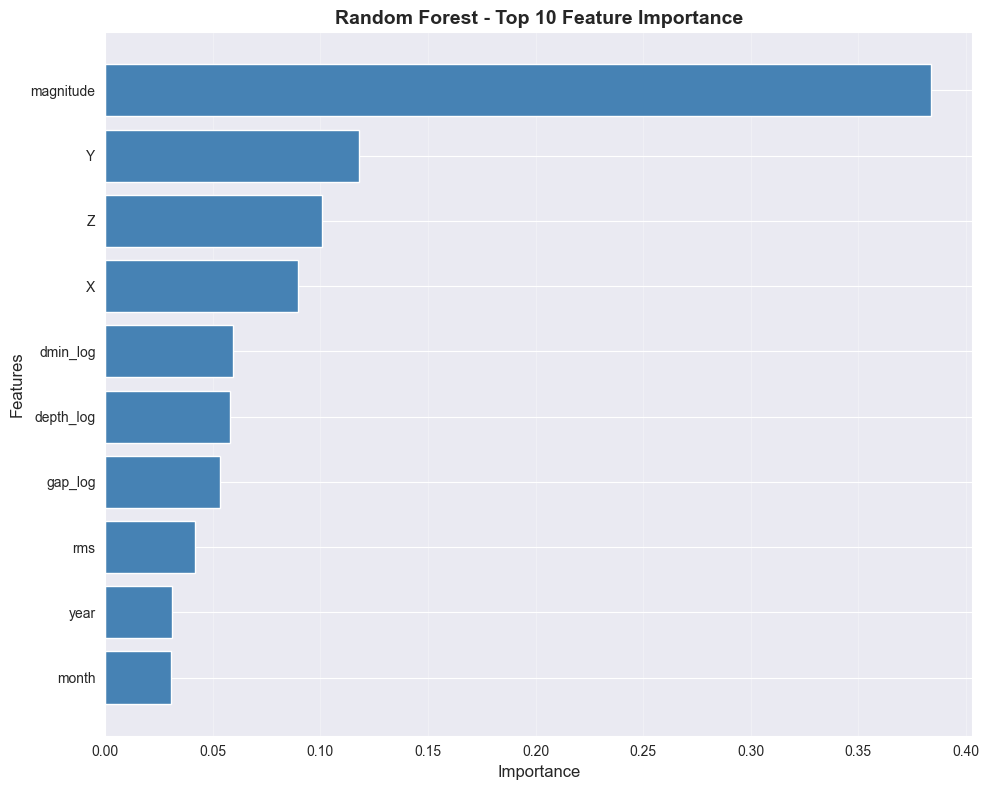

In [87]:
# Check feature importance
feature_importance = rf.feature_importances_

importance_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Top 10

plt.figure(figsize=(10, 8))
top_n = 10
top_features = importance_df.head(top_n)

plt.barh(top_features['feature'], top_features['importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Random Forest - Top {top_n} Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


#### 3. KNN

In [88]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))


              precision    recall  f1-score   support

           0       0.81      0.92      0.86       231
           1       0.79      0.59      0.67       121

    accuracy                           0.80       352
   macro avg       0.80      0.75      0.77       352
weighted avg       0.80      0.80      0.80       352

Confusion Matrix:
 [[212  19]
 [ 50  71]]


In [89]:
# from sklearn.linear_model import LogisticRegression
#
# log_clf = LogisticRegression(max_iter=2000)
# log_clf.fit(X_train_onehot_scaled, y_train_onehot)
#
# log_pred = log_clf.predict(X_test_onehot_scaled)
#
# from sklearn.metrics import accuracy_score
#
# print("Logistic Regression Accuracy:", accuracy_score(y_test_onehot, log_pred))
# print("Logistic Regression Classification Report:")
# print(classification_report(y_test_onehot, log_pred))

In [90]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       231
           1       0.85      0.83      0.84       121

    accuracy                           0.89       352
   macro avg       0.88      0.87      0.88       352
weighted avg       0.89      0.89      0.89       352

